In [21]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
from cai_robustness_metrics.metrics.prediction_rejection_curve import PredictionRejectionCurve
sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"


In [22]:
def get_prc(run, file):
    path = run["params.csv_path"]
    ap = run[AP]
    wp = run[WP]
    df = pd.read_csv(path + f"/{file}.csv")

    preds = df.iloc[:,0:10].to_numpy()
    preds = softmax(preds, axis=1)
    targs = df['targets'].to_numpy()

    prc = PredictionRejectionCurve(preds, targs)
    return prc

In [41]:
experiments = [
    {'id': "27",  'name': 'resnet18' }, 
    
    {'id': "24",  'name': 'lenet' }, 
    {'id': "25", 'name': 'lenetplus' },
    {'id': "26",  'name': 'squeezenet' }, 
]

In [42]:
data = []
for exp in experiments:
    d = mlflow.search_runs(
        experiment_ids=exp["id"],
        filter_string="tags.stage = 'eval'",
        output_format="pandas",
    )
    if 'train_id' in exp.keys():
        d2 = mlflow.search_runs(
            experiment_ids=exp["train_id"],
            filter_string="tags.stage = 'eval'",
            output_format="pandas",
        )
        d = pd.concat([d, d2])

    data.append({'name': exp["name"], 'data': d})


In [43]:
results = []
for exp in data:
    d = exp["data"]

    run = d[d["tags.type"] == "eval"].iloc[0]
    prc = get_prc(run, 'preds')

    results.append({"model": exp["name"], "acc": run["metrics.test/acc"], "wp": "FP", "prcr": prc.get_prediction_rejection_ratio()})  

    quant = d[d["tags.type"] == "quantization"]
    quant = quant[quant[AP] == "7"]
    for i in range(len(quant)):
        run = quant.iloc[i]

        prc = get_prc(run, 'q_preds')

        results.append({"model": exp["name"], "acc": run["metrics.q_test/acc"], "ap": run[AP], "wp": run[WP], "prcr": prc.get_prediction_rejection_ratio()})    



In [44]:
df = pd.DataFrame(results)
df = df.sort_values('wp', ascending=False)

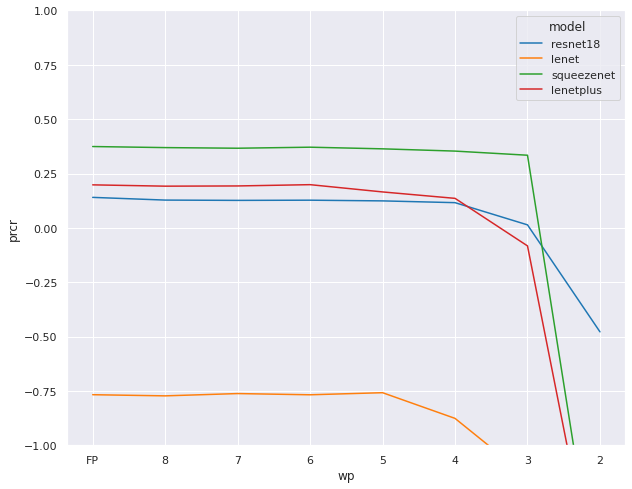

In [45]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
grid = sns.lineplot(data=df, x="wp", y="prcr",  hue="model", dashes=False)
#grid.set(xscale="log")
plt.ylim(-1, 1)

plt.savefig("/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/pred_rejection/quant.jpg")

In [46]:
results = []
for exp in data:
    d = exp["data"]

    run = d[d["tags.type"] == "pruning"]
    run = run[run["tags.pruning_method"] == "unstructured_l1"].iloc[0]
    prc = get_prc(run, 'p_preds')

    results.append({"model": exp["name"], "acc": run["metrics.test/acc"], "wp": "FP", "prcr": prc.get_prediction_rejection_ratio()})  

    quant = d[d["tags.type"] == "pruning + quantization"]
    quant = quant[quant[AP] == "7"]
    for i in range(len(quant)):
        run = quant.iloc[i]

        prc = get_prc(run, 'q_preds')

        results.append({"model": exp["name"], "acc": run["metrics.q_test/acc"], "ap": run[AP], "wp": run[WP], "prcr": prc.get_prediction_rejection_ratio()})    



In [47]:
df = pd.DataFrame(results)
df = df.sort_values('wp', ascending=False)

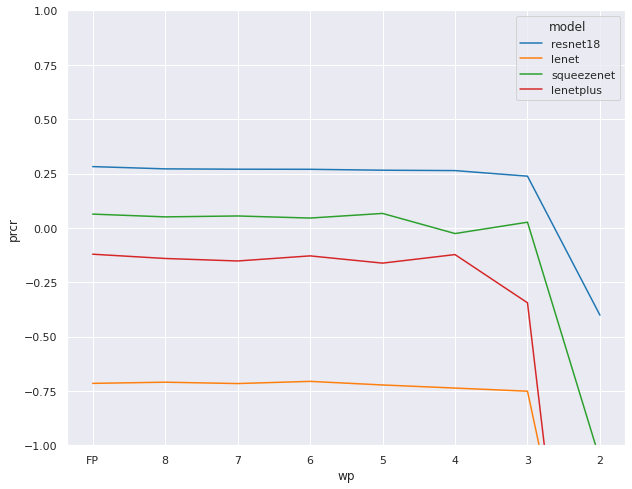

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
grid = sns.lineplot(data=df, x="wp", y="prcr",  hue="model", dashes=False)
#grid.set(xscale="log")
plt.ylim(-1, 1)

plt.savefig("/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/pred_rejection/prun-quant.jpg")